# Preamble

**In this notebook I'll explore how to run normal (pooled) OLS, Fixed Effects, and Random Effects in Python, R, and Stata.**

 - Two useful Python packages that can be used for this purpose are [`statsmodels`](https://www.statsmodels.org/stable/index.html) and [`linearmodels`](https://bashtage.github.io/linearmodels/). The `linearmodels` packages is geared more towards econometrics. Here's I'll explore the usage of both.
 - There are several R packages that could be used here. I use [`plm`](https://cran.r-project.org/web/packages/plm/index.html) here. However, it may be better to use [`lfe`](https://cran.r-project.org/web/packages/lfe/index.html) or [`fixest`](https://cran.r-project.org/web/packages/fixest/index.html). (TO DO)
 - I've used [`rpy2`](https://pypi.org/project/rpy2/) to run the `R` code from within a Python kernel. It may be easier to simply skip these notebook cells and paste the code directly into a separate R interpreter. 
 - The required data files (`lme.dta` and `St11-12_jtrain1.dta`) are in the same folder as this notebook. Instructions are also provided to download them from other sources.
 - The Stata code does not run in the Jupyter notebook. I've simply pasted the code and the results. The full code is available in `fixed_and_random_effects.do`, also located in this same folder.
 - If you run this in Google colab, you need to install `rpy2` and `linearmodels` first, as well as download the required data files. The cell below will do this for you.

### Usage with Google Colab

If using Google Colab, uncomment and run the cells in this section first. 

In [1]:
!apt-get install r-base
!pip install rpy2
!pip install linearmodels

Reading package lists... Done
Building dependency tree       
Reading state information... Done
r-base is already the newest version (3.6.3-1bionic).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
     |████████████████████████████████| 1.5MB 7.8MB/s 


In [2]:
# If using Google Colab, uncomment and run this cell first
import urllib.request

url_prefix = "https://github.com/jmbejara/comp-econ-sp19/blob/master/lectures/4-23_Panel_Data/"
files = [
    "15_2_Wooldridge_Intro.png",
    "lme.dta",
    "Example_10_4_Wooldridge_Panel.png",
    "Example_10_5_Wooldridge_Panel.png",
    "fixed_and_random_effects.do",
    "St11-12_jtrain1.dta",
    ]
for file in files:
    url = url_prefix + file + "?raw=true"
    urllib.request.urlretrieve(url, f'./{file}')

In [3]:
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [4]:
%%R
install.packages("foreign")
install.packages("plm")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘miscTools’, ‘bibtex’, ‘gbRd’, ‘bdsmatrix’, ‘zoo’, ‘sandwich’, ‘lmtest’, ‘maxLik’, ‘Rdpack’, ‘Formula’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/miscTools_0.6-26.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 25420 bytes (24 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console

## Usage with all platforms

The previous section applies only if you're running this on Google Colab. The main document that applies to all platform begins here.

In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import linearmodels
from statsmodels.sandbox.regression.predstd import wls_prediction_std

np.random.seed(9876789)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# OLS

In [7]:
# Set up simple example data with some missing data
nsample = 100
x = np.linspace(0, 10, 100)
X = np.column_stack((x, x**2))
beta = np.array([0.1, 10])
e = np.random.normal(size=nsample)
alpha = 1
y = alpha + X @ beta + e
X[3,1] = np.nan # missing data

In [8]:
df = pd.DataFrame(X, columns=['x1', 'x2'])
df['y'] = y
df.head()

,x1,x2,y
0,0.00000,0.000000,0.159484
1,0.10101,0.010203,2.709627
2,0.20202,0.040812,1.893866
3,0.30303,NaN,1.440418
4,0.40404,0.163249,5.607196


## `statsmodels` standard API

I'll start by using the regular API.

In [9]:
rhs = sm.add_constant(df[['x1', 'x2']])
lhs = df['y']
res = sm.OLS(lhs, rhs, missing='drop').fit()

In [10]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.955e+06
Date:                Tue, 25 Aug 2020   Prob (F-statistic):          1.09e-236
Time:                        20:24:09   Log-Likelihood:                -145.23
No. Observations:                  99   AIC:                             296.5
Df Residuals:                      96   BIC:                             304.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4086      0.324      4.341      0.000       0.765       2.053
x1            -0.0654      0.148     -0.441      0.660      -0.360       0.229
x2            10.0123      0.014    702.595      0.000       9.984      10.041
==============================================================================
Omnibus:                        1.981   Durbin-Watson:                   2.228
Prob(Omnibus):                  0.371   Jarque-Bera (JB):                1.764
Skew:                           0.209   Prob(JB):                        0.414
Kurtosis:                       2.498   Cond. No.                         149.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
# All results stored in "results" object.
# E.g., to programatically retrieve parameters
res.params

const     1.408565
x1       -0.065398
x2       10.012289
dtype: float64

## `statsmodels` formula API

Now we use the `formula` API. This uses R-style regression formula notation, via the `patsy` package.

You need to make sure to import the separate submodule to access this API, via `import statsmodels.formula.api as smf`

In [12]:
results = smf.ols(formula="y ~ x1 + x2", data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.955e+06
Date:                Tue, 25 Aug 2020   Prob (F-statistic):          1.09e-236
Time:                        20:24:09   Log-Likelihood:                -145.23
No. Observations:                  99   AIC:                             296.5
Df Residuals:                      96   BIC:                             304.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4086      0.324      4.341      0.000       0.765       2.053
x1            -0.0654      0.148     -0.441      0.660      -0.360       0.229
x2            10.0123      0.014    702.595      0.000       9.984      10.041
==============================================================================
Omnibus:                        1.981   Durbin-Watson:                   2.228
Prob(Omnibus):                  0.371   Jarque-Bera (JB):                1.764
Skew:                           0.209   Prob(JB):                        0.414
Kurtosis:                       2.498   Cond. No.                         149.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## OLS in Base R

In [13]:
%%R -i df
head(df)

         x1         x2         y
0 0.0000000 0.00000000 0.1594841
1 0.1010101 0.01020304 2.7096267
2 0.2020202 0.04081216 1.8938657
3 0.3030303        NaN 1.4404177
4 0.4040404 0.16324865 5.6071962
5 0.5050505 0.25507601 4.0141596


In [14]:
%%R 
fit = lm(y ~ x1 + x2, df)
fit


Call:
lm(formula = y ~ x1 + x2, data = df)

Coefficients:
(Intercept)           x1           x2  
     1.4086      -0.0654      10.0123  



In [15]:
%%R
summary(fit)


Call:
lm(formula = y ~ x1 + x2, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.07542 -0.76563  0.03925  0.70802  2.59056 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.40856    0.32446   4.341 3.51e-05 ***
x1          -0.06540    0.14831  -0.441     0.66    
x2          10.01229    0.01425 702.595  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.065 on 96 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 3.955e+06 on 2 and 96 DF,  p-value: < 2.2e-16



# Fixed Effects

Here I'll test out fixed effects estimation. In particular, I want to compare the outcomes that I get in Python to the output that I get from Stata. I want to make sure I'm getting the same results. To do this, I'll be using a data exercise from Wooldridge's panel data book. I have solutions to the odd problems in this book and Stata results. So, I can verify that my Stata results are accurate and then proceed with the analysis in Python.


## Linear Mixed Effects Models


#### In `statsmodels`
Here is a quick example of the syntax from `statsmodels`. This is taken from here: http://statsmodels.sourceforge.net/devel/mixed_linear.html

In [16]:
import statsmodels.api as sm 
import statsmodels.formula.api as smf

data = sm.datasets.get_rdataset("dietox", "geepack").data
data.head()

,Pig,Evit,Cu,Litter,Start,Weight,Feed,Time
0,4601,Evit000,Cu000,1,26.5,26.50000,NaN,1
1,4601,Evit000,Cu000,1,26.5,27.59999,5.200005,2
2,4601,Evit000,Cu000,1,26.5,36.50000,17.600000,3
3,4601,Evit000,Cu000,1,26.5,40.29999,28.500000,4
4,4601,Evit000,Cu000,1,26.5,49.09998,45.200001,5


In [17]:
data.describe()

,Pig,Litter,Start,Weight,Feed,Time
count,861.000000,861.000000,861.000000,861.000000,789.000000,861.000000
mean,6238.319396,12.135889,25.672701,60.725769,80.728645,6.480836
std,1323.845928,7.427252,3.624336,24.978881,52.877736,3.444735
min,4601.000000,1.000000,15.000000,15.000000,3.300003,1.000000
25%,4857.000000,5.000000,23.799990,38.299990,32.800003,3.000000
50%,5866.000000,11.000000,25.700000,59.199980,74.499996,6.000000
75%,8050.000000,20.000000,27.299990,81.199950,123.000000,9.000000
max,8442.000000,24.000000,35.399990,117.000000,224.500000,12.000000


In [18]:
md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"]) 
mdf = md.fit() 
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: Weight    
No. Observations: 861     Method:             REML      
No. Groups:       72      Scale:              11.3669   
Min. group size:  11      Likelihood:         -2404.7753
Max. group size:  12      Converged:          Yes       
Mean group size:  12.0                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept    15.724    0.788  19.952 0.000 14.179 17.268
Time          6.943    0.033 207.939 0.000  6.877  7.008
Group Var    40.394    2.149                            
========================================================

"""

In [19]:
md = sm.MixedLM.from_formula("Weight ~ Time", data, groups=data["Pig"]) 
mdf = md.fit() 
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: Weight    
No. Observations: 861     Method:             REML      
No. Groups:       72      Scale:              11.3669   
Min. group size:  11      Likelihood:         -2404.7753
Max. group size:  12      Converged:          Yes       
Mean group size:  12.0                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept    15.724    0.788  19.952 0.000 14.179 17.268
Time          6.943    0.033 207.939 0.000  6.877  7.008
Group Var    40.394    2.149                            
========================================================

"""

#### In Stata

Now I'll confirm that I get the same calculation in Stata.

In [20]:
#Save file as Stata file
# data.to_stata('lme.dta')

In Stata, call the following commands:

    use "C:\Users\Jeremy\Documents\GitRepositories\Learn\python\statistics-and-data-analysis\General\fixed-and-random-effects\lme.dta", clear
    
    xtreg Weight Time, i(Pig)
    
This produces the following output:

```
Random-effects GLS regression                   Number of obs     =        861
Group variable: Pig                             Number of groups  =         72

R-sq:                                           Obs per group:
     within  = 0.9821                                         min =         11
     between = 0.0370                                         avg =       12.0
     overall = 0.9177                                         max =         12

                                                Wald chi2(1)      =   43261.79
corr(u_i, X)   = 0 (assumed)                    Prob > chi2       =     0.0000

------------------------------------------------------------------------------
      Weight |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
        Time |   6.942504   .0333783   207.99   0.000     6.877084    7.007925
       _cons |   15.72353   .7902282    19.90   0.000     14.17471    17.27234
-------------+----------------------------------------------------------------
     sigma_u |  6.3769509
     sigma_e |  3.3714948
         rho |  .78154074   (fraction of variance due to u_i)
------------------------------------------------------------------------------
```

#### With `plm` in R

Some information on how to do this in R: https://dss.princeton.edu/training/Panel101R.pdf

In [21]:
%%R
library(foreign)
library(plm)

In [22]:
%%R
# df = read.dta('lme.dta')
df = read.dta('https://github.com/jmbejara/comp-econ-sp19/blob/master/lectures/4-23_Panel_Data/lme.dta?raw=true')
fixed = plm(Weight ~ Time, data=df, index=c('Pig'), model='within')
summary(fixed)

Oneway (individual) effect Within Model

Call:
plm(formula = Weight ~ Time, data = df, model = "within", index = c("Pig"))

Unbalanced Panel: n = 72, T = 11-12, N = 861

Residuals:
    Min.  1st Qu.   Median  3rd Qu.     Max. 
-15.9401  -1.9190  -0.2842   1.6538  16.4499 

Coefficients:
     Estimate Std. Error t-value  Pr(>|t|)    
Time 6.942398   0.033388  207.93 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    500420
Residual Sum of Squares: 8957.2
R-Squared:      0.9821
Adj. R-Squared: 0.98047
F-statistic: 43236.1 on 1 and 788 DF, p-value: < 2.22e-16


As you can see, the results are the same.

## Wooldridge Panel Data: Chapter 10


I will replicate the examples that are found here: http://www.ats.ucla.edu/stat/stata/examples/eacspd/chapter10.htmb (Now here: https://stats.idre.ucla.edu/stata/examples/eacspd/econometric-analysis-of-cross-section-and-panel-data-by-jeffrey-m-wooldridgechapter-10-basic-linear-unobserved-effects-panel-data-models/) 

**jtrain1 data**

This data comes from the paper "Are Training Subsidies for Firms Effective? The Michigan Experience", by Holzer, et al. 1993. 

Abstract:
> This paper explores the effects of a state-financed training grant program for manufacturing firms in Michigan. Using a three-year panel of data from a unique survey of firms that applied for these grants, the authors estimate the effects of receipt of a grant on total hours of training in the firm and the product scrap rate. They find that receipt of these grants is associated with a large and significant, though one-time, increase in training hours, and with a more lasting reduction in scrap rates.


### Random Effects Model

#### Example 10.4 on page 261 using jtrain1.dta.


> We now use the data in JTRAIN1.RAW to estimate the effect of job training grants on firm scrap rates, using a random e¤ects analysis. There are 54 firms that reported scrap rates for each of the years 1987, 1988, and 1989. Grants were not awarded in 1987. Some firms received grants in 1988, others received grants in 1989, and a firm could not receive a grant twice. Since there are firms in 1989 that received a grant only in 1988, it is important to allow the grant effect to persist one period. The estimated equation is




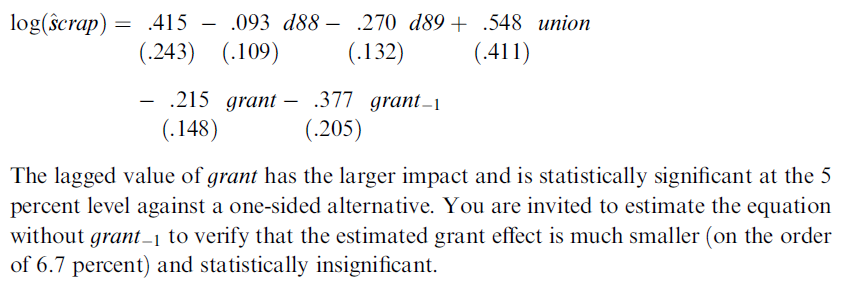

In this example, I'm trying to replicate the following Stata code.

    //use jtrain1, clear
    use http://www.stata.com/data/jwooldridge/eacsap/jtrain1, clear
    xtreg lscrap d88 d89 union grant grant_1, i( fcode)

In [23]:
import pandas as pd
import pandas
import statsmodels.formula.api as smf

In [24]:
# #download and save the correct datasets
# import urllib
# testfile = urllib.request.URLopener()
# testfile.retrieve("http://www.stata.com/data/jwooldridge/eacsap/jtrain1.dta", "jtrain1.dta")

Note that once you download this file, you need to use Stata to save this in Stata 11/12 format or it will not work. I have already done this and named the new copy of the file

In [25]:
# Does not work with this version of Stata
# df = pd.read_stata('jtrain1.dta')

In [26]:
#Open converted file
url = "http://www.stata.com/data/jwooldridge/eacsap/jtrain1.dta"
# df = pd.read_stata('St11-12_jtrain1.dta')
df = pd.read_stata(url)

In [27]:
# The Stata Reader doesn't work with all versions of Stata files
# This Stata file has been converted to one that it can read.
with open('St11-12_jtrain1.dta', 'rb') as file:
    stata_file = sm.iolib.foreign.StataReader(file)

# Print Variables names and labels
for var in stata_file.variables():
    print(f'{var.name}: {var.label}')

year: 1987, 1988, or 1989
fcode: firm code number
employ: # employees at plant
sales: annual sales, $
avgsal: average employee salary
scrap: scrap rate (per 100 items)
rework: rework rate (per 100 items)
tothrs: total hours training
union: =1 if unionized
grant: = 1 if received grant
d89: = 1 if year = 1989
d88: = 1 if year = 1988
totrain: total employees trained
hrsemp: tothrs/totrain
lscrap: log(scrap)
lemploy: log(employ)
lsales: log(sales)
lrework: log(rework)
lhrsemp: log(1 + hrsemp)
lscrap_1: lagged lscrap; missing 1987
grant_1: lagged grant; assumed 0 in 1987
clscrap: lscrap - lscrap_1; year > 1987
cgrant: grant - grant_1
clemploy: lemploy - lemploy[_n-1]
clsales: lavgsal - lavgsal[_n-1]
lavgsal: log(avgsal)
clavgsal: lavgsal - lavgsal[_n-1]
cgrant_1: cgrant[_n-1]
chrsemp: hrsemp - hrsemp[_n-1]
clhrsemp: lhrsemp - lhrsemp[_n-1]


/usr/local/lib/python3.6/dist-packages/statsmodels/iolib/foreign.py:272: FutureWarning: StataReader is deprecated as of 0.10.0 and will be removed in a future version.  Use pandas.read_stata or pandas.io.stata.StataReader instead.
  FutureWarning)


In [28]:
#df = df.set_index(['year'])
df.head()

,year,fcode,employ,sales,avgsal,scrap,rework,tothrs,union,grant,d89,d88,totrain,hrsemp,lscrap,lemploy,lsales,lrework,lhrsemp,lscrap_1,grant_1,clscrap,cgrant,clemploy,clsales,lavgsal,clavgsal,cgrant_1,chrsemp,clhrsemp
0,1987,410032.0,100.0,47000000.0,35000.0,NaN,NaN,12.0,0,0,0,0,100.0,12.000000,NaN,4.605170,17.665659,NaN,2.564949,NaN,0,NaN,0,NaN,NaN,10.463103,NaN,NaN,NaN,NaN
1,1988,410032.0,131.0,43000000.0,37000.0,NaN,NaN,8.0,0,0,0,1,50.0,3.053435,NaN,4.875197,17.576710,NaN,1.399565,NaN,0,NaN,0,0.270027,-0.088949,10.518673,0.055570,0.0,-8.946565,-1.165385
2,1989,410032.0,123.0,49000000.0,39000.0,NaN,NaN,8.0,0,0,1,0,50.0,3.252033,NaN,4.812184,17.707331,NaN,1.447397,NaN,0,NaN,0,-0.063013,0.130621,10.571317,0.052644,0.0,0.198597,0.047832
3,1987,410440.0,12.0,1560000.0,10500.0,NaN,NaN,12.0,0,0,0,0,12.0,12.000000,NaN,2.484907,14.260197,NaN,2.564949,NaN,0,NaN,0,NaN,NaN,9.259130,NaN,NaN,NaN,NaN
4,1988,410440.0,13.0,1970000.0,11000.0,NaN,NaN,12.0,0,0,0,1,13.0,12.000000,NaN,2.564949,14.493544,NaN,2.564949,NaN,0,NaN,0,0.080043,0.233347,9.305651,0.046520,0.0,0.000000,0.000000


In [29]:
df[['lscrap', 'union', 'fcode','sales', 'rework']].describe()

,lscrap,union,fcode,sales,rework
count,162.000000,471.000000,471.000000,373.0,123.000000
mean,0.393681,0.197452,415709.000000,6116037.0,3.473984
std,1.486471,0.398500,4022.922363,7912517.0,5.462482
min,-4.605170,0.000000,410032.000000,110000.0,0.000000
25%,-0.523431,0.000000,410604.000000,1550000.0,0.350000
50%,0.347123,0.000000,418084.000000,3000000.0,1.160000
75%,1.386294,0.000000,419309.000000,7700000.0,4.000000
max,3.401197,1.000000,419486.000000,54000000.0,40.000000


#### With `statsmodels`

I believe that this is working because it doesn't know how to handle the missing data. I'm going to drop all the missing data and then try again.

In [30]:
# The following wont work if you don't drop the missing values.
df2 = df.copy()

# df2 = df[['lscrap', 'd88', 'd89', 'union', 'grant', 'grant_1', 'fcode']].dropna()

In [31]:
# The following wont work if you don't drop the missing values.

# md = smf.mixedlm("lscrap ~ d88 + d89 + union + grant + grant_1", df2, groups=df2["fcode"])
# mdf = md.fit() 
# mdf.summary()

In [32]:
# The following wont work if you don't drop the missing values.

# md = smf.mixedlm("lscrap ~ union", df2, groups=df2["fcode"])
# mdf = md.fit() 
# mdf.summary()

In [33]:
df2 = df[['lscrap', 'd88', 'd89', 'union', 'grant', 'grant_1', 'fcode']].dropna()
md = smf.mixedlm("lscrap ~ d88 + d89 + union + grant + grant_1", df2, groups=df2["fcode"])
mdf = md.fit() 
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: lscrap   
No. Observations: 162     Method:             REML     
No. Groups:       54      Scale:              0.2478   
Min. group size:  3       Likelihood:         -205.9266
Max. group size:  3       Converged:          Yes      
Mean group size:  3.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.415    0.244  1.698 0.089 -0.064  0.894
d88          -0.093    0.109 -0.856 0.392 -0.307  0.120
d89          -0.270    0.132 -2.050 0.040 -0.527 -0.012
union         0.548    0.412  1.329 0.184 -0.260  1.356
grant        -0.215    0.148 -1.455 0.146 -0.505  0.075
grant_1      -0.378    0.205 -1.839 0.066 -0.780  0.025
Group Var     1.955    0.984                           
=======================================================

"""

#### With `linearmodels`

In [34]:
df2 = df[['lscrap', 'd88', 'd89', 'union', 'grant', 'grant_1', 'fcode', 'year']].dropna().set_index(['fcode', 'year'])
md = linearmodels.RandomEffects.from_formula("lscrap ~ 1+ d88 + d89 + union + grant + grant_1 + EntityEffects", data=df2)
mdf = md.fit() 
mdf

Dep. Variable:,lscrap,R-squared:,0.1486
Estimator:,RandomEffects,R-squared (Between):,0.0184
No. Observations:,162,R-squared (Within):,0.2005
Date:,"Tue, Aug 25 2020",R-squared (Overall):,0.0349
Time:,20:24:15,Log-likelihood,-113.26
Cov. Estimator:,Unadjusted,,
,,F-statistic:,5.4474
Entities:,54,P-value,0.0001
Avg Obs:,3.0000,Distribution:,"F(5,156)"
Min Obs:,3.0000,,
Max Obs:,3.0000,F-statistic (robust):,5.4474


#### With `plm` in R

Some info on how to do this in R: https://dss.princeton.edu/training/Panel101R.pdf

In [35]:
dfr = df2.reset_index()

In [36]:
%%R -i dfr
reg = plm(lscrap ~ d88 + d89 + union + grant + grant_1, data=dfr, index=c('fcode'), model='random')
summary(reg)

Oneway (individual) effect Random Effect Model 
   (Swamy-Arora's transformation)

Call:
plm(formula = lscrap ~ d88 + d89 + union + grant + grant_1, data = dfr, 
    model = "random", index = c("fcode"))

Balanced Panel: n = 54, T = 3, N = 162

Effects:
                 var std.dev share
idiosyncratic 0.2477  0.4977 0.114
individual    1.9322  1.3900 0.886
theta: 0.7975

Residuals:
     Min.   1st Qu.    Median   3rd Qu.      Max. 
-2.546798 -0.223892  0.040554  0.255287  1.549792 

Coefficients:
             Estimate Std. Error z-value Pr(>|z|)  
(Intercept)  0.414833   0.243432  1.7041  0.08836 .
d88         -0.093452   0.109156 -0.8561  0.39192  
d89         -0.269834   0.131650 -2.0496  0.04040 *
union        0.547802   0.410625  1.3341  0.18218  
grant       -0.214696   0.147784 -1.4528  0.14629  
grant_1     -0.377070   0.205352 -1.8362  0.06633 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    45.509
Residual Sum of Squares: 38.798
R-

If I don't include the index, not that R still understands the
Panel structure:

    Balanced Panel: n=54, T=3, N=162

That is because it simply assumes that the
first column is the entity and the second is the time variable. Also, notice that the default is entity effects.

In [37]:
%%R -i dfr
# This works too.
reg = plm(lscrap ~ d88 + d89 + union + grant + grant_1, data=dfr, model='random')
summary(reg)

Oneway (individual) effect Random Effect Model 
   (Swamy-Arora's transformation)

Call:
plm(formula = lscrap ~ d88 + d89 + union + grant + grant_1, data = dfr, 
    model = "random")

Balanced Panel: n = 54, T = 3, N = 162

Effects:
                 var std.dev share
idiosyncratic 0.2477  0.4977 0.114
individual    1.9322  1.3900 0.886
theta: 0.7975

Residuals:
     Min.   1st Qu.    Median   3rd Qu.      Max. 
-2.546798 -0.223892  0.040554  0.255287  1.549792 

Coefficients:
             Estimate Std. Error z-value Pr(>|z|)  
(Intercept)  0.414833   0.243432  1.7041  0.08836 .
d88         -0.093452   0.109156 -0.8561  0.39192  
d89         -0.269834   0.131650 -2.0496  0.04040 *
union        0.547802   0.410625  1.3341  0.18218  
grant       -0.214696   0.147784 -1.4528  0.14629  
grant_1     -0.377070   0.205352 -1.8362  0.06633 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    45.509
Residual Sum of Squares: 38.798
R-Squared:      0.1474

In [38]:
%%R -i dfr
# I'm not sure why this doesn't work.
# reg = plm(lscrap ~ union + grant + grant_1, data=dfr, index=c('fcode', 'year'), model='random', effect='twoways')
# summary(reg)

NULL


#### In Stata

Compare this to the Stata output here. They are the same

```
//use jtrain1, clear
use http://www.stata.com/data/jwooldridge/eacsap/jtrain1, clear
xtreg lscrap d88 d89 union grant grant_1, i( fcode)
```

```
Random-effects GLS regression                   Number of obs      =       162
Group variable (i): fcode                       Number of groups   =        54

R-sq:  within  = 0.2006                         Obs per group: min =         3
       between = 0.0206                                        avg =       3.0
       overall = 0.0361                                        max =         3

Random effects u_i ~ Gaussian                   Wald chi2(5)       =     26.99
corr(u_i, X)       = 0 (assumed)                Prob > chi2        =    0.0001

------------------------------------------------------------------------------
      lscrap |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
         d88 |  -.0934519   .1091559    -0.86   0.392    -.3073937    .1204898
         d89 |  -.2698336   .1316496    -2.05   0.040     -.527862   -.0118052
       union |   .5478021    .410625     1.33   0.182    -.2570081    1.352612
       grant |   -.214696   .1477838    -1.45   0.146     -.504347    .0749549
     grant_1 |  -.3770698   .2053516    -1.84   0.066    -.7795515    .0254119
       _cons |   .4148333   .2434322     1.70   0.088    -.0622851    .8919518
-------------+----------------------------------------------------------------
     sigma_u |  1.3900287
     sigma_e |  .49774421
         rho |  .88634984   (fraction of variance due to u_i)
------------------------------------------------------------------------------
```

Below I give the Stata output when `robust` is used. The regular procedure above seems to be closer to the Python output.

```
. xtreg lscrap d88 d89 union grant grant_1, i( fcode) robust

Random-effects GLS regression                   Number of obs     =        162
Group variable: fcode                           Number of groups  =         54

R-sq:                                           Obs per group:
     within  = 0.2006                                         min =          3
     between = 0.0206                                         avg =        3.0
     overall = 0.0361                                         max =          3

                                                Wald chi2(5)      =      27.65
corr(u_i, X)   = 0 (assumed)                    Prob > chi2       =     0.0000

                                 (Std. Err. adjusted for 54 clusters in fcode)
------------------------------------------------------------------------------
             |               Robust
      lscrap |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
         d88 |  -.0934519   .0938166    -1.00   0.319    -.2773291    .0904253
         d89 |  -.2698336   .1885186    -1.43   0.152    -.6393232     .099656
       union |   .5478021   .4023672     1.36   0.173     -.240823    1.336427
       grant |  -.2146961   .1311183    -1.64   0.102    -.4716832    .0422911
     grant_1 |  -.3770698   .2674417    -1.41   0.159    -.9012458    .1471062
       _cons |   .4148333   .2673996     1.55   0.121    -.1092603     .938927
-------------+----------------------------------------------------------------
     sigma_u |  1.3900287
     sigma_e |  .49774421
         rho |  .88634984   (fraction of variance due to u_i)
------------------------------------------------------------------------------
```

As can be read here (http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.mixed_linear_model.MixedLM.from_formula.html), "this method currently does not correctly handle missing values, so missing values should be explicitly dropped from the DataFrame before calling this method."

## Fixed Effects


### Example 10.5 on page 272 using jtrain1.dta.



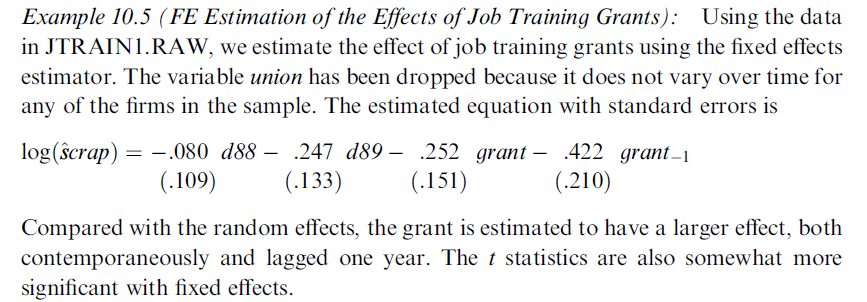


In this example, I'm trying to replicate the following Stata code.

    //use jtrain1, clear
    use http://www.stata.com/data/jwooldridge/eacsap/jtrain1, clear
    xtreg lscrap d88 d89 union grant grant_1, i( fcode) fe
    
To do this, I'm going to use the direction that is given here: http://stackoverflow.com/questions/24195432/fixed-effect-in-pandas-or-statsmodels

#### Using `linearmodels`

In [39]:
import pandas as pd
import pandas
import statsmodels.formula.api as smf
df = pd.read_stata('St11-12_jtrain1.dta')

In [40]:
df.columns

Index(['year', 'fcode', 'employ', 'sales', 'avgsal', 'scrap', 'rework',
       'tothrs', 'union', 'grant', 'd89', 'd88', 'totrain', 'hrsemp', 'lscrap',
       'lemploy', 'lsales', 'lrework', 'lhrsemp', 'lscrap_1', 'grant_1',
       'clscrap', 'cgrant', 'clemploy', 'clsales', 'lavgsal', 'clavgsal',
       'cgrant_1', 'chrsemp', 'clhrsemp'],
      dtype='object')

In [41]:
df2.head()

lscrap  d88  d89  union  grant  grant_1
fcode    year                                           
410523.0 1987 -2.813411    0    0      0      0        0
         1988 -2.995732    1    0      0      0        0
         1989 -2.995732    0    1      0      0        0
410538.0 1987  0.970779    0    0      1      0        0
         1988  1.007958    1    0      1      0        0

In [42]:
df2 = df[['lscrap', 'union', 'grant', 'grant_1', 'fcode', 'year']].dropna().set_index(['fcode', 'year'])
reg = linearmodels.PanelOLS.from_formula("lscrap ~ grant + grant_1 + EntityEffects + TimeEffects", data=df2)
# This wont work below since the variable 'union' doesn't vary over time for
# any of the firms in the sample
# reg = linearmodels.PanelOLS.from_formula("lscrap ~ union + grant + grant_1 + EntityEffects + TimeEffects", data=df2)
reg_fitted = reg.fit() 
reg_fitted

Dep. Variable:,lscrap,R-squared:,0.0411
Estimator:,PanelOLS,R-squared (Between):,-0.0552
No. Observations:,162,R-squared (Within):,0.1478
Date:,"Tue, Aug 25 2020",R-squared (Overall):,-0.0381
Time:,20:24:16,Log-likelihood,-80.946
Cov. Estimator:,Unadjusted,,
,,F-statistic:,2.2294
Entities:,54,P-value,0.1127
Avg Obs:,3.0000,Distribution:,"F(2,104)"
Min Obs:,3.0000,,
Max Obs:,3.0000,F-statistic (robust):,2.2294


In [43]:
# # This doesn't give the correct results
# df2 = df[['d88', 'd89', 'lscrap', 'union', 'grant', 'grant_1', 'fcode', 'year']].dropna()
# reg = smf.mixedlm("lscrap ~ d88 + d89 + grant + grant_1", df2, groups=df2["fcode"])
# reg_fitted = reg.fit()
# reg_fitted.summary()

In [44]:
# df2 = df.set_index(['year', 'fcode'])
# reg = pd.stats.plm.PanelOLS(y=df2['lscrap'], x=df2[['d88', 'd89', 'union', 'grant', 'grant_1']], time_effects=True)
# reg

Note that the indexes must be in the correct order. The above results do not match the Stata output. Below is the correct ordering.

In [45]:
# df2 = df.set_index(['fcode', 'year'])
# reg = pd.stats.plm.PanelOLS(y=df2['lscrap'], x=df2[['d88', 'd89', 'union', 'grant', 'grant_1']], time_effects=True)
# reg

#### Using Stata

Compare this to the Stata output. It gives the same coefficients. Some of the tests are not the same, however.

```
//use jtrain1, clear
use http://www.stata.com/data/jwooldridge/eacsap/jtrain1, clear
xtreg lscrap d88 d89 union grant grant_1, i( fcode)
```


```
Fixed-effects (within) regression               Number of obs      =       162
Group variable (i): fcode                       Number of groups   =        54

R-sq:  within  = 0.2010                         Obs per group: min =         3
       between = 0.0079                                        avg =       3.0
       overall = 0.0068                                        max =         3

                                                F(4,104)           =      6.54
corr(u_i, Xb)  = -0.0714                        Prob > F           =    0.0001

------------------------------------------------------------------------------
      lscrap |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
         d88 |  -.0802157   .1094751    -0.73   0.465     -.297309    .1368776
         d89 |  -.2472028   .1332183    -1.86   0.066    -.5113797    .0169741
       union |  (dropped)
       grant |  -.2523149    .150629    -1.68   0.097    -.5510178    .0463881
     grant_1 |  -.4215895      .2102    -2.01   0.047    -.8384239   -.0047551
       _cons |   .5974341   .0677344     8.82   0.000     .4631142    .7317539
-------------+----------------------------------------------------------------
     sigma_u |   1.438982
     sigma_e |  .49774421
         rho |  .89313867   (fraction of variance due to u_i)
------------------------------------------------------------------------------
F test that all u_i=0:     F(53, 104) =    23.87             Prob > F = 0.0000
```

#### Using `plm` in R

In [46]:
%%R -i df
reg = plm(lscrap ~ d88 + d89 + union + grant + grant_1, df, index=c('fcode', 'year'), model='within')
summary(reg)

Oneway (individual) effect Within Model

Call:
plm(formula = lscrap ~ d88 + d89 + union + grant + grant_1, data = df, 
    model = "within", index = c("fcode", "year"))

Balanced Panel: n = 54, T = 3, N = 162

Residuals:
     Min.   1st Qu.    Median   3rd Qu.      Max. 
-2.286936 -0.112387 -0.017841  0.144272  1.426674 

Coefficients:
         Estimate Std. Error t-value Pr(>|t|)  
d88     -0.080216   0.109475 -0.7327  0.46537  
d89     -0.247203   0.133218 -1.8556  0.06634 .
grant   -0.252315   0.150629 -1.6751  0.09692 .
grant_1 -0.421590   0.210200 -2.0057  0.04749 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    32.25
Residual Sum of Squares: 25.766
R-Squared:      0.20105
Adj. R-Squared: -0.23684
F-statistic: 6.54259 on 4 and 104 DF, p-value: 9.7741e-05


If we don't want to put in time dummies manually, all we need to do
is to specify "two-way" fixed effects. Note that we need to supply the 
index properly. That is, the individual index first, followed by the time
index second. If you don't specify the index, it will assume that the first
two columns are the index, again in the order of individual and then time.

See p. 72 of this: https://cran.r-project.org/web/packages/plm/plm.pdf and see p. 5 of this https://cran.r-project.org/web/packages/plm/vignettes/plm.pdf

In [47]:
%%R -i df
# This works so that we don't have to manually put in time dummies
reg = plm(lscrap ~ union + grant + grant_1, df, index=c('fcode', 'year'), model='within', effect='twoways')
summary(reg)

Twoways effects Within Model

Call:
plm(formula = lscrap ~ union + grant + grant_1, data = df, effect = "twoways", 
    model = "within", index = c("fcode", "year"))

Balanced Panel: n = 54, T = 3, N = 162

Residuals:
     Min.   1st Qu.    Median   3rd Qu.      Max. 
-2.286936 -0.112387 -0.017841  0.144272  1.426674 

Coefficients:
        Estimate Std. Error t-value Pr(>|t|)  
grant   -0.25231    0.15063 -1.6751  0.09692 .
grant_1 -0.42159    0.21020 -2.0057  0.04749 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    26.871
Residual Sum of Squares: 25.766
R-Squared:      0.041111
Adj. R-Squared: -0.48443
F-statistic: 2.22942 on 2 and 104 DF, p-value: 0.11271


A simple Monte Carlo demonstration using a different package can be found here: https://www.r-bloggers.com/linear-models-with-multiple-fixed-effects/